# Predicting Pulsar Star
Pulsar candidates collected during the High Time Resolution Universe Survey
- original dataset: https://archive.ics.uci.edu/ml/datasets/HTRU2
- kaggle competition: https://www.kaggle.com/datasets/colearninglounge/predicting-pulsar-starintermediate 

### About Dataset
**Description**

Pulsars are a rare type of Neutron star that produce radio emission detectable here on Earth. They are of considerable scientific interest as probes of space-time, the inter-stellar medium, and states of matter. Machine learning tools are now being used to automatically label pulsar candidates to facilitate rapid analysis. Classification systems in particular are being widely adopted,which treat the candidate data sets as binary classification problems.

Credit goes to Pavan Raj (https://www.kaggle.com/pavanraj159) from where the dataset has been collected. For the purpose of creating a challenge, certain modifications have been done to the dataset.

Original dataset can be acquired from the link Predicting a Pulsar Star (https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star)
Attribute Information:

Each candidate is described by 8 continuous variables, and a single class variable. The first four are simple statistics obtained from the integrated pulse profile (folded profile). This is an array of continuous variables that describe a longitude-resolved version of the signal that has been averaged in both time and frequency . The remaining four variables are similarly obtained from the DM-SNR curve . These are summarised below:

1. Mean of the integrated profile.
2. Standard deviation of the integrated profile.
3. Excess kurtosis of the integrated profile.
4. Skewness of the integrated profile.
5. Mean of the DM-SNR curve.
6. Standard deviation of the DM-SNR curve.
7. Excess kurtosis of the DM-SNR curve.
8. Skewness of the DM-SNR curve.
9. Class

HTRU 2 Summary
17,898 total examples.
1,639 positive examples.
16,259 negative examples.

Source: https://archive.ics.uci.edu/ml/datasets/HTRU2

Dr Robert Lyon
University of Manchester
School of Physics and Astronomy
Alan Turing Building
Manchester M13 9PL
United Kingdom
robert.lyon '@' manchester.ac.uk

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline
from IPython.display import Image
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import (accuracy_score, classification_report, ConfusionMatrixDisplay,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from xgboost import XGBClassifier

from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

#test

2023-06-12 16:40:48.808840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## EDA

In [2]:
# read data and rename column names for better readability and clarity.
new_columns = ['Profile_mean', 'Profile_std', 'Profile_kurtosis', 'Profile_skewness',
               'DM_SNR_mean', 'DM_SNR_std', 'DM_SNR_kurtosis', 'DM_SNR_skewness', 'target']

df_train = pd.read_csv('pulsar_data_train.csv')
df_test = pd.read_csv('pulsar_data_test.csv')

df_train.columns = new_columns
df_test.columns = new_columns
df_train.head()

,Profile_mean,Profile_std,Profile_kurtosis,Profile_skewness,DM_SNR_mean,DM_SNR_std,DM_SNR_kurtosis,DM_SNR_skewness,target
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [3]:
print(df_train.duplicated().sum(), df_test.duplicated().sum())

0 0


No duplicates in data

In [4]:
# basic informations of trainset
display(df_train.describe())
df_train.info()
df_train.isna().sum()

,Profile_mean,Profile_std,Profile_kurtosis,Profile_skewness,DM_SNR_mean,DM_SNR_std,DM_SNR_kurtosis,DM_SNR_skewness,target
count,12528.000000,12528.000000,10793.000000,12528.000000,12528.000000,11350.000000,12528.000000,11903.000000,12528.000000
mean,111.041841,46.521437,0.478548,1.778431,12.674758,26.351318,8.333489,105.525779,0.092034
std,25.672828,6.801077,1.064708,6.208450,29.613230,19.610842,4.535783,107.399585,0.289085
min,5.812500,24.772042,-1.738021,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.871094,42.362222,0.024652,-0.188142,1.910535,14.404353,5.803063,35.199899,0.000000
50%,115.183594,46.931022,0.223678,0.203317,2.792642,18.412402,8.451097,83.126301,0.000000
75%,127.109375,50.979103,0.473125,0.932374,5.413253,28.337418,10.727927,139.997850,0.000000
max,189.734375,91.808628,8.069522,68.101622,222.421405,110.642211,34.539844,1191.000837,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Profile_mean      12528 non-null  float64
 1   Profile_std       12528 non-null  float64
 2   Profile_kurtosis  10793 non-null  float64
 3   Profile_skewness  12528 non-null  float64
 4   DM_SNR_mean       12528 non-null  float64
 5   DM_SNR_std        11350 non-null  float64
 6   DM_SNR_kurtosis   12528 non-null  float64
 7   DM_SNR_skewness   11903 non-null  float64
 8   target            12528 non-null  float64
dtypes: float64(9)
memory usage: 881.0 KB


Profile_mean           0
Profile_std            0
Profile_kurtosis    1735
Profile_skewness       0
DM_SNR_mean            0
DM_SNR_std          1178
DM_SNR_kurtosis        0
DM_SNR_skewness      625
target                 0
dtype: int64

In [5]:
# kaggle test
#display(df_test.head())
display(df_test.describe())
df_test.info()
df_test.isna().sum()

,Profile_mean,Profile_std,Profile_kurtosis,Profile_skewness,DM_SNR_mean,DM_SNR_std,DM_SNR_kurtosis,DM_SNR_skewness,target
count,5370.000000,5370.000000,4603.000000,5370.000000,5370.000000,4846.000000,5370.000000,5126.000000,0.0
mean,111.168917,46.615074,0.483676,1.751260,12.473587,26.425371,8.233724,102.869088,NaN
std,25.608635,6.940638,1.076893,6.072820,29.145134,19.384489,4.435683,104.748418,NaN
min,6.179688,24.791612,-1.876011,-1.764717,0.213211,7.370432,-2.721857,-1.964998,NaN
25%,101.041016,42.408020,0.030643,-0.189557,1.956522,14.555826,5.700461,33.817330,NaN
50%,114.757812,47.031304,0.227314,0.186468,2.830686,18.549670,8.383695,81.392046,NaN
75%,127.023438,51.133444,0.475056,0.918807,5.590301,28.681787,10.632265,136.893502,NaN
max,192.617188,98.778911,7.608370,65.385974,223.392141,109.712649,34.539844,1191.000837,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5370 entries, 0 to 5369
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Profile_mean      5370 non-null   float64
 1   Profile_std       5370 non-null   float64
 2   Profile_kurtosis  4603 non-null   float64
 3   Profile_skewness  5370 non-null   float64
 4   DM_SNR_mean       5370 non-null   float64
 5   DM_SNR_std        4846 non-null   float64
 6   DM_SNR_kurtosis   5370 non-null   float64
 7   DM_SNR_skewness   5126 non-null   float64
 8   target            0 non-null      float64
dtypes: float64(9)
memory usage: 377.7 KB


Profile_mean           0
Profile_std            0
Profile_kurtosis     767
Profile_skewness       0
DM_SNR_mean            0
DM_SNR_std           524
DM_SNR_kurtosis        0
DM_SNR_skewness      244
target              5370
dtype: int64

There are missing values in: 
- **Excess kurtosis of the integrated profile**,
- **Standard deviation of the DM-SNR curve** and
- **Skewness of the DM-SNR curve**

in both datasets (train and test). The test dataset does not contain any values for the target class and is used as the aim dataset.

In [6]:
print('Missing values in % (trainset)')
print('---'*20)
df_train.isna().sum()/len(df_train)*100

Missing values in % (trainset)
------------------------------------------------------------


Profile_mean         0.000000
Profile_std          0.000000
Profile_kurtosis    13.848978
Profile_skewness     0.000000
DM_SNR_mean          0.000000
DM_SNR_std           9.402937
DM_SNR_kurtosis      0.000000
DM_SNR_skewness      4.988825
target               0.000000
dtype: float64

In [7]:
print('Missing values in % (testset)')
print('---'*20)
df_test.isna().sum()/len(df_test)*100

Missing values in % (testset)
------------------------------------------------------------


Profile_mean          0.000000
Profile_std           0.000000
Profile_kurtosis     14.283054
Profile_skewness      0.000000
DM_SNR_mean           0.000000
DM_SNR_std            9.757914
DM_SNR_kurtosis       0.000000
DM_SNR_skewness       4.543762
target              100.000000
dtype: float64

In both datasets, the percentage of missing data is roughly the same. The following section aims to investigate how the missing data can be handled to improve the quality of data analysis and modeling.

target
0.0    11375
1.0     1153
Name: count, dtype: int64


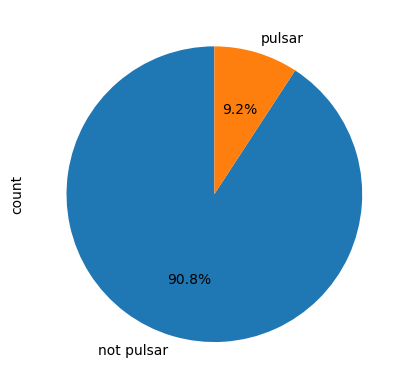

In [8]:
# target distribution
df_train['target'].value_counts().plot(kind='pie', autopct='%.1f%%', startangle=90, labels=['not pulsar', 'pulsar'])
print(df_train['target'].value_counts())

The data is highly imbalanced. Only 9.2% of the datapoints is classified as pulsar.

<Axes: >

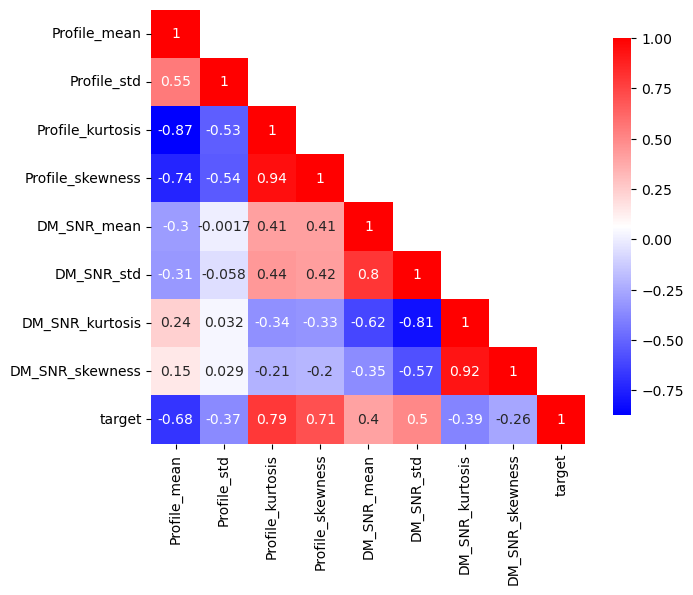

In [9]:
# correlations of the features
corr_matrix = df_train.corr()

fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(data=corr_matrix,
            annot=True,
            square=True,
           cbar_kws={"shrink": .7},
           cmap='bwr',
           mask=np.triu(corr_matrix,+1))

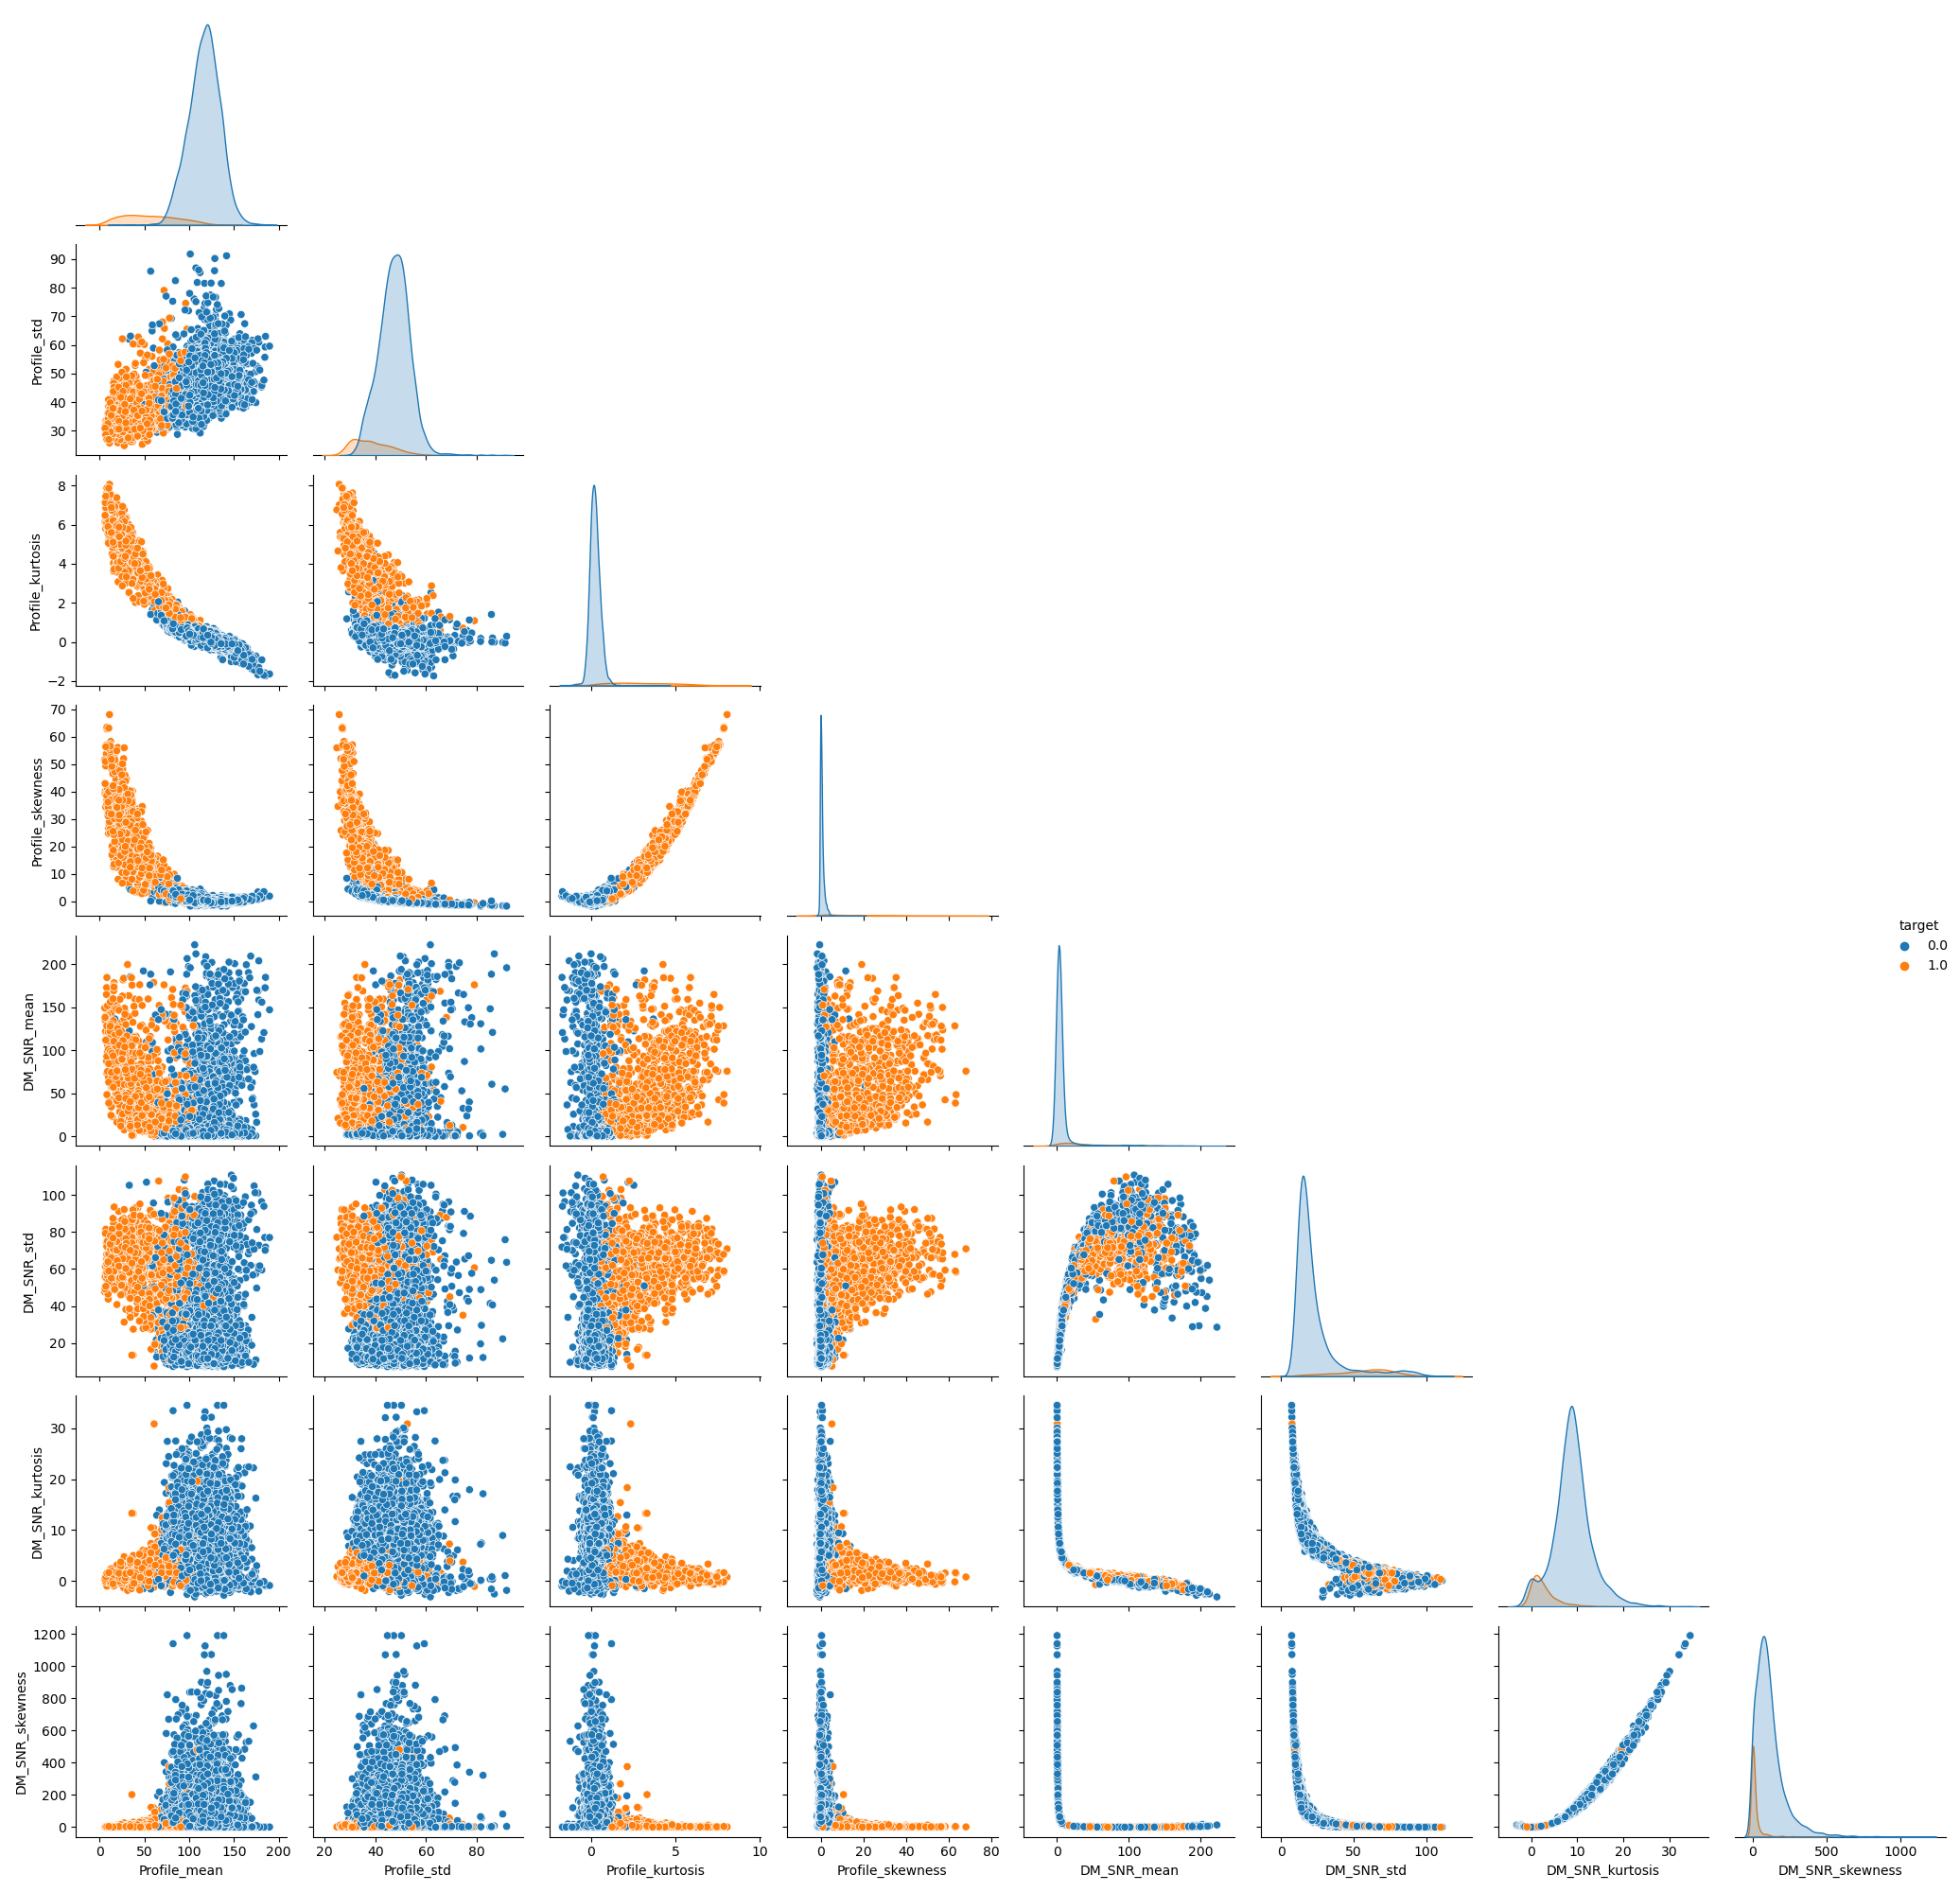

In [14]:
# check distribution of each feature

#sns.pairplot(data=df_train, hue='target', corner=True)
#plt.tight_layout()

#plt.savefig('pairplot_kaggle_train.png')
Image('pairplot_kaggle_train.png')

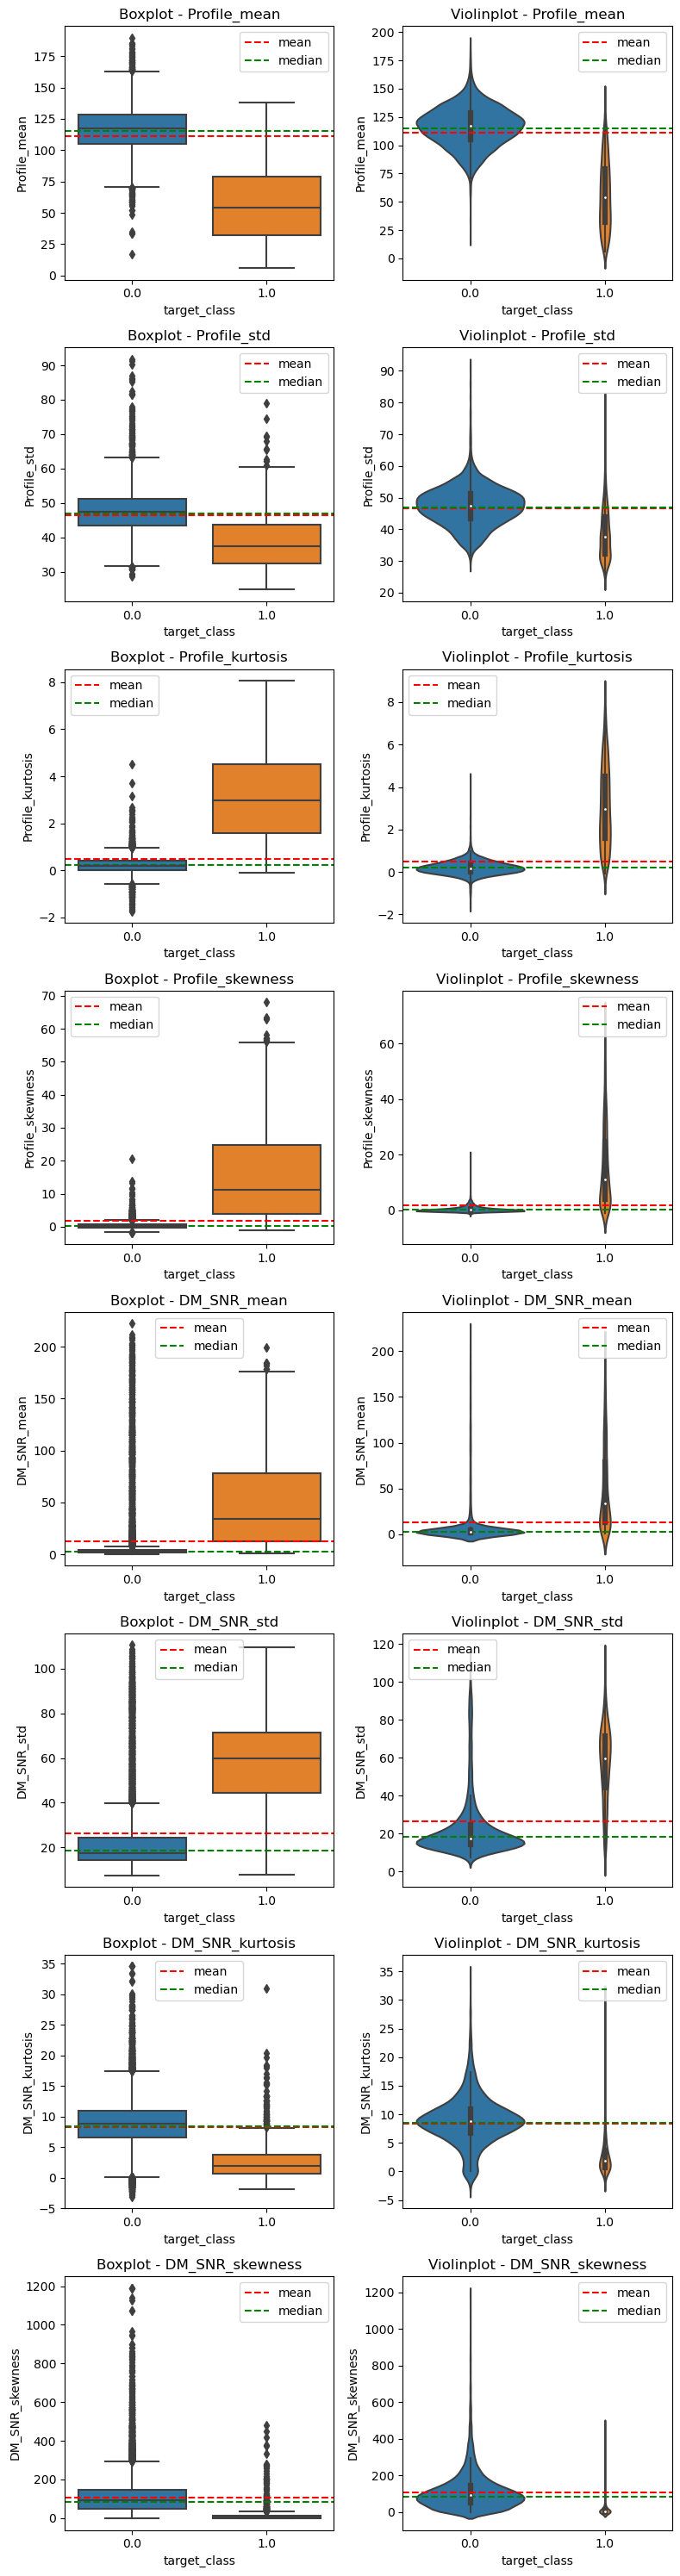

In [15]:
features = df_train.columns.to_list()

fig, axs = plt.subplots(nrows=8, ncols=2, figsize=(8, 30))
for i, feature in enumerate(features[:-1]):
    ax1 = axs[i,0]
    ax2 = axs[i,1]

    sns.boxplot(x=features[-1], y=feature, data=df_train, ax=ax1)
    ax1.set_xlabel('target_class')
    ax1.set_ylabel(feature)
    ax1.set_title('Boxplot - ' + feature)
    ax1.axhline(df_train[feature].mean(), color='r', linestyle='--', label='mean')
    ax1.axhline(df_train[feature].median(), color='g', linestyle='--', label='median')
    ax1.legend()
    
    sns.violinplot(x=features[-1], y=feature, data=df_train, ax=ax2, scale='count')
    ax2.set_xlabel('target_class')
    ax2.set_ylabel(feature)
    ax2.set_title('Violinplot - ' + feature)
    ax2.axhline(df_train[feature].mean(), color='r', linestyle='--', label='mean')
    ax2.axhline(df_train[feature].median(), color='g', linestyle='--', label='median')
    ax2.legend()
    
plt.tight_layout()

plt.show()
#plt.savefig('box_violin_trainset.png')

## Train-Validation-Test Split
The test set obtained from Kaggle does not include the target variable,
so it is no longer useful and can be repurposed as the aim dataset.

For modeling purposes, we will perform a train-validation-test split with a distribution of 70-15-15.
This allows us to allocate 70% of the data for training, 15% for testing, and 15% for validation.

In [17]:
# perform train-validation-test split
#read in again to remove previous changes
new_columns = ['Profile_mean', 'Profile_std', 'Profile_kurtosis', 'Profile_skewness',
               'DM_SNR_mean', 'DM_SNR_std', 'DM_SNR_kurtosis', 'DM_SNR_skewness', 'target']

df = pd.read_csv('pulsar_data_train.csv')
df.columns = new_columns

In [18]:
# define features and target
features = df.drop(columns='target')
target = df['target']


# First split: Training data and rest (validation data + test data)
X_train, X_rest, y_train, y_rest = train_test_split(features, target,
                                                    test_size=0.3,
                                                    random_state=42)

# Second split: Test data and validation data
X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest,
                                                test_size=0.5,
                                                random_state=42)

**Now we have:**
- X_train: Training data
- y_train: Target for training data
- X_test: Test data
- y_test: Target for test data
- X_val: Validation data
- y_val: Target for validation data

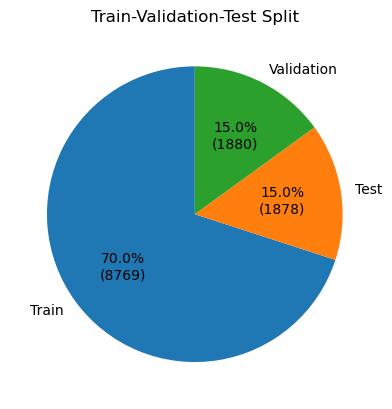

In [19]:
# visualize the split
counts = [len(X_train), len(X_test), len(X_val)]

def my_fmt(x):
    total = sum(counts)
    absolute = int(x / 100. * total)
    return '{:.1f}%\n({:})'.format(x, absolute)

plt.pie(counts, labels=['Train', 'Test', 'Validation'], autopct=my_fmt, startangle=90)
plt.title('Train-Validation-Test Split')
plt.show()

## clean data

In [20]:
# Handle missing values
num_cols = ['Profile_mean', 'Profile_std', 'Profile_kurtosis', 'Profile_skewness',
               'DM_SNR_mean', 'DM_SNR_std', 'DM_SNR_kurtosis', 'DM_SNR_skewness']

cat_cols = []


cleaner = ColumnTransformer(transformers=[("knn_imputer", KNNImputer(n_neighbors=5, weights="uniform"), num_cols)],
                            remainder = "passthrough"
                           )

# apply imputing on datasets
X_train = pd.DataFrame(cleaner.fit_transform(X_train), columns=num_cols)
X_val = pd.DataFrame(cleaner.transform(X_val), columns=num_cols)
X_test = pd.DataFrame(cleaner.transform(X_test), columns=num_cols)

#print(X_train.info(), X_test.info(), X_val.info())

# Modeling

In [21]:
# helper function to compare the scores of the different models
model_results = []

def calculate_scores(y_val, y_pred, name):
    """
    Calculates and returns the accuracy, precision, recall, and F1 score for the given validation and predicted labels.

    Args:
        y_val (array-like): The true labels for the validation set.
        y_pred (array-like): The predicted labels for the validation set.
        name (str): The name of the model used to make the predictions.

    Returns:
        dict: A dictionary containing the name of the model and the calculated accuracy, precision, recall, and F1 score.
    """
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1_scr = f1_score(y_val, y_pred)

    scores = {'name': name,
              'accuracy': accuracy,
              'precision': precision,
              'recall': recall,
              'F1': f1_scr,
              }

    return scores

## Random Forest

In [22]:
model_rf = Pipeline(steps = [("scaler", StandardScaler()),
                             ("rfc", RandomForestClassifier(n_estimators = 10,
                                                         max_depth = 5,
                                                         random_state = 42,
                                                         n_jobs = -1))]
                   )

model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_val)
print(classification_report(y_pred_rf, y_val))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1723
         1.0       0.80      0.93      0.86       157

    accuracy                           0.97      1880
   macro avg       0.90      0.95      0.92      1880
weighted avg       0.98      0.97      0.98      1880



In [ ]:
model_std_rfc = Pipeline([("scaler", StandardScaler()),
                           ("rfc", RandomForestClassifier(n_estimators = 10,
                                                          class_weight = "balanced",
                                                         max_depth = 5,
                                                         max_leaf_nodes = 5,
                                                         random_state = 42,
                                                         n_jobs = -1))])

n_estimator_space = np.geomspace(10, 1000, 15, dtype="int")
max_depth_space = np.geomspace(1, 10, 5, dtype="int")
max_leaf_nodes_space = np.geomspace(2, 10, 5, dtype="int")

search_space = {"rfc__n_estimators" : [26],
                "rfc__max_depth" : [3],
               "rfc__max_leaf_nodes": [10]}

grid_search = GridSearchCV(estimator = model_std_rfc,
                          param_grid = search_space,
                          scoring = "f1",
                          cv =5,
                          n_jobs = -1)

grid_search.fit(X_train, y_train)

print(grid_search.best_score_, grid_search.best_estimator_, grid_search.best_params_)

In [ ]:
model_std_rfc = Pipeline([("scaler", StandardScaler()),
                           ("rfc", RandomForestClassifier(n_estimators = 26,
                                                         max_depth = 3,
                                                         max_leaf_nodes = 10,
                                                         random_state = 42,
                                                         n_jobs = -1))])

model_std_rfc.fit(X_train, y_train)
y_val_pred = model_std_rfc.predict(X_val)
print(f1_score(y_val, y_val_pred))

In [ ]:
y_test_pred = model_std_rfc.predict(X_test)
print(f1_score(y_test, y_test_pred))

In [ ]:
model_results.append(calculate_scores(y_test, y_test_pred, name='RF_Grid'))

pd.DataFrame(model_results)

### RF - ROC

In [ ]:
# calculate probability
y_pred_proba = model_std_rfc.predict_proba(X_test)
# calculate roc curve values
false_positive_rate, recall, threshold = roc_curve(y_test,
                                                   y_pred_proba[:, 1],
                                                   #y_pred_proba,
                                                   drop_intermediate=False) 

# figure and axes intialisation
fig, ax = plt.subplots()

# reference lines
ax.plot([0, 1], ls = "--", label='random model')  # blue diagonal
ax.plot([0, 0], [1, 0], c=".7", ls='--', label='ideal model')  # grey vertical
ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# roc curve
ax.plot(false_positive_rate, recall, label='model_RFC')

# labels
ax.set_title("Receiver Operating Characteristic")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positibe Rate")
ax.legend();


### RF - Confusion Matrix

In [ ]:
cm_rfc = confusion_matrix(y_test, y_test_pred)

cm_rfc_display = ConfusionMatrixDisplay(cm_rfc).plot()

### RF - Feature Importance

In [ ]:
model_std_rfc.steps

RFC_feat_importance = pd.Series(data=model_std_rfc.steps[1][1].feature_importances_,
                                index=X_train.columns)
RFC_feat_importance_sorted = RFC_feat_importance.sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#99cced']*7 + ['#17415f']

RFC_feat_importance_sorted.plot(kind="barh", color=colors, width = 0.8);

# Customisations------------------------------------------------------------------------------------------
ax.set_title(label="Importance of values in Random Forest Classification Model",
            size = 16)
ax.set_xlabel('Relative importance',
             size = 12,
             position=[0, 0],
             horizontalalignment='left')
ax.set_yticklabels(ax.get_yticklabels(), 
                   size=13)
ax.set_ylabel('Features',
              size = 12)

for idx in range(len(RFC_feat_importance_sorted.index)):
    ax.text(s='{}%'.format(int(100*RFC_feat_importance_sorted.iloc[idx])),
            x=RFC_feat_importance_sorted.iloc[idx]+0.005,
            y=idx, size=12,
            color='black'
           )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_xticklabels([]);

### RF - Plot Tree

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (14,5))
tree.plot_tree(model_std_rfc.named_steps["rfc"].estimators_[0],
               feature_names = X_train.columns, 
               class_names=["Is Not Pulsar", "Is Pulsar"],
               filled = True);

fig.savefig('rfc_individualtree_[0].png')

## SVM - baseline

In [ ]:
# Create a pipeline that scales the data and applies SMOTE
pipe = make_pipeline(StandardScaler(), SMOTE(), SVC())

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Make predictions on new data
y_pred_baseline = pipe.predict(X_val)

print(classification_report(y_pred_baseline, y_val))

### SVM - GridSearch

In [ ]:
# Define the parameter grid for the inner loop
#param_grid = {
#    'svc__C': [0.01, 0.1, 1, 10, 100],
#    'svc__kernel': ['rbf'], # 'linear', 'poly', 'sigmoid'
#    'svc__gamma': [0.01, 0.1, 1, 10, 100],
#    'svc__degree': [2] # 3,4
#}
param_grid = {
    'svc__C': [10],
    'svc__kernel': ['rbf'], # 'linear', 'poly', 'sigmoid'
    'svc__gamma': [0.01],
    'svc__degree': [2] # 3,4
}


# Create a GridSearchCV object for the inner loop
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid.fit(X_train, y_train)

# Remove the 'svc__' prefix from the keys in best_params_
best_params = {key.split('__')[1]: value for key, value in grid.best_params_.items()}

# Create a pipeline with the best hyperparameters from the grid search
pipe_grid = make_pipeline(StandardScaler(), SMOTE(), SVC(**best_params, probability=True))

# Fit the pipeline to the training data
pipe_grid.fit(X_train, y_train)

# Make predictions on new data using the pipeline with the best hyperparameters from the grid search
y_pred_grid = pipe_grid.predict(X_val)

# Print best paramas
print(best_params)


In [ ]:
print(f1_score(y_val, y_val_pred))

In [ ]:
y_test_svm_pred = pipe_grid.predict(X_test)

In [ ]:
model_results.append(calculate_scores(y_test, y_test_svm_pred, name='SVM_Grid'))

pd.DataFrame(model_results)

### SVM - ROC

In [ ]:
# calculate probability
y_svm_pred_proba = pipe_grid.predict_proba(X_test)
# calculate roc curve values
false_positive_rate, recall, threshold = roc_curve(y_test,
                                                   y_svm_pred_proba[:, 1],
                                                   #y_test_svm_pred,
                                                   drop_intermediate=False) 

# figure and axes intialisation
fig, ax = plt.subplots()

# reference lines
ax.plot([0, 1], ls = "--", label='random model')  # blue diagonal
ax.plot([0, 0], [1, 0], c=".7", ls='--', label='ideal model')  # grey vertical
ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# roc curve
ax.plot(false_positive_rate, recall, label='model_SVM')

# labels
ax.set_title("Receiver Operating Characteristic")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("Recall")
ax.legend();

### SVM - Confusion Matrix

In [ ]:
cm_svm = confusion_matrix(y_test, y_test_svm_pred)

cm_svm_display = ConfusionMatrixDisplay(cm_svm).plot()

In [ ]:
# show results
pd.DataFrame(model_results).T

## Neural Network (ANN)

In [ ]:
# define f1 score 
def f1_score_ann(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

In [ ]:
# preprocessing for ANN

scaler = StandardScaler()


# apply preprocessing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)


# apply SMOTE
smote = SMOTE(random_state=42)
X_train_sampled, y_train_sampled = smote.fit_resample(X_train_scaled, y_train)

print('Original dataset distribution of', y_train.value_counts())
print('Resampled dataset distribution of', y_train_sampled.value_counts())

In [ ]:
tf.keras.utils.set_random_seed(42)
dropout_rate = 0.4

# define model
model_ann = Sequential()

# define hidden layers
hidden_1 = Dense(units=8, activation='relu', input_dim=X_train_sampled.shape[1])
hidden_2 = Dense(units=8, activation='relu')


# define the dropout layers
dropout_1 = Dropout(rate=dropout_rate, seed=42)
dropout_2 = Dropout(rate=dropout_rate, seed=42)

# define output layer
output_layer  = Dense(units=1, activation='sigmoid')

# add layers 
model_ann.add(hidden_1)
model_ann.add(dropout_1)
model_ann.add(hidden_2)
model_ann.add(dropout_2)
model_ann.add(output_layer)



#-----------------------------------------------------------------------------------------
from tensorflow.keras.optimizers import Adam
adam_custom = Adam(learning_rate=0.0005) # deafult 0.001

#-----------------------------------------------------------------------------------------
# compile model    

#model_ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score_ann])
model_ann.compile(optimizer=adam_custom, loss='binary_crossentropy', metrics=[f1_score_ann])
#model_ann.compile(optimizer=adam_custom, loss='binary_crossentropy', metrics='accuracy')
#---------------------------------------------------------------------------------------------
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5)
# train model 
hist_ann = model_ann.fit(X_train_sampled,
                         y_train_sampled,
                         epochs=100, 
                         batch_size=512,
                         verbose=0,
                         #shuffle=False,
                         #callbacks=[early_stop],
                         validation_data=(X_val_scaled, y_val))
#----------------------------------------------------------------------------------------------
# plot loss function and score of used metrics
# define figure and axes
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

# plot training & validation loss values
#axs[0].plot(hist_ann.history['loss'])
#axs[0].plot(hist_ann.history['val_loss'])
axs[0].plot(range(1, len(hist_ann.history['loss']) + 1), hist_ann.history['loss'])
axs[0].plot(range(1, len(hist_ann.history['val_loss']) + 1), hist_ann.history['val_loss'])
axs[0].set(title='Model loss', ylabel='Loss', xlabel='Epoch')
axs[0].legend(['train', 'val'])

# plot training & validation metric score values
axs[1].plot(range(1, len(hist_ann.history[model_ann.metrics_names[1]]) + 1), hist_ann.history[model_ann.metrics_names[1]])
axs[1].plot(range(1, len(hist_ann.history['val_' + model_ann.metrics_names[1]]) + 1), hist_ann.history['val_' + model_ann.metrics_names[1]])
axs[1].set(title='Model ' + model_ann.metrics_names[1], ylabel=model_ann.metrics_names[1], xlabel='Epoch')
axs[1].legend(['train', 'val'], loc='upper left')
#-----------------------------------------------------------------------------------------------
# predict and print classification report

#predict and calculate probability
y_pred = (model_ann.predict(X_test_scaled) > 0.5).astype('int8')
y_pred_proba = model_ann.predict(X_test_scaled)

y_true = y_test

print(classification_report(y_true, y_pred))

#evaluate
print('Evaluation-----------------')
print('Recall :', recall_score(y_true, y_pred))
print('Precision :', precision_score(y_true, y_pred))
print('F1 :', f1_score(y_true, y_pred))
print('Accuracy :', accuracy_score(y_true, y_pred))
print('ROC_AUC :', roc_auc_score(y_true, y_pred_proba))


### ANN - ROC

In [ ]:
# calculate probability
y_pred_proba = model_ann.predict(X_test_scaled)
# calculate roc curve values
false_positive_rate, recall, threshold = roc_curve(y_test,
                                                   #y_pred_proba[:, 1],
                                                   y_pred_proba,
                                                   drop_intermediate=False) 

# figure and axes intialisation
fig, ax = plt.subplots()

# reference lines
ax.plot([0, 1], ls = "--", label='random model')  # blue diagonal
ax.plot([0, 0], [1, 0], c=".7", ls='--', label='ideal model')  # grey vertical
ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# roc curve
ax.plot(false_positive_rate, recall, label='model_ANN')

# labels
ax.set_title("Receiver Operating Characteristic")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("Recall")
ax.legend()


### ANN - Confusion Matrix

In [ ]:
cm_ann = confusion_matrix(y_true, y_pred)

cm_ann_display = ConfusionMatrixDisplay(cm_ann).plot()

###  ANN - Polinominal Features and PCA

In [ ]:
# preprocessing for ANN
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=16))
])



# apply preprocessing
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)
X_val_scaled = pipeline.transform(X_val)


# apply SMOTE
smote = SMOTE(random_state=42)
X_train_sampled, y_train_sampled = smote.fit_resample(X_train_scaled, y_train)

print('Original dataset distribution of', X_train.shape)
print('Resampled train dataset distribution of', X_train_sampled.shape)
print('Resampled test dataset distribution of', X_test_scaled.shape)
print(pipeline.named_steps['pca'].explained_variance_ratio_.sum())

#---------------------------------------------------------
df_corr = pd.DataFrame(X_train_sampled)
corr = df_corr.corr()
fig, axs = plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, square=True, cbar_kws={"shrink": .7})

In [ ]:
tf.keras.utils.set_random_seed(42)
dropout_rate = 0.6

# define model
model_ann = Sequential()

# define hidden layers
hidden_1 = Dense(units=16, activation='relu', input_dim=X_train_sampled.shape[1])
hidden_2 = Dense(units=16, activation='relu')

# define the dropout layers
dropout_1 = Dropout(rate=dropout_rate, seed=42)
dropout_2 = Dropout(rate=dropout_rate, seed=42)

# define output layer
output_layer  = Dense(units=1, activation='sigmoid')

# add layers 
model_ann.add(hidden_1)
model_ann.add(dropout_1)
model_ann.add(hidden_2)
model_ann.add(dropout_2)
model_ann.add(output_layer)

#-----------------------------------------------------------------------------------------
from tensorflow.keras.optimizers import Adam
adam_custom = Adam(learning_rate=0.0007) # deafult 0.001

#-----------------------------------------------------------------------------------------
# compile model    

model_ann.compile(optimizer=adam_custom, loss='binary_crossentropy', metrics=[f1_score_ann])

#---------------------------------------------------------------------------------------------

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=20)

# train model 
hist_ann = model_ann.fit(X_train_sampled,
                         y_train_sampled,
                         epochs=100, 
                         batch_size=1024,
                         verbose=1,
                         #shuffle=False,
                         callbacks=[early_stop],
                         validation_data=(X_val_scaled, y_val))
#########################################################################################################################################################
#----------------------------------------------------------------------------------------------
# plot loss function and score of used metrics
# define figure and axes
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

# plot training & validation loss values
#axs[0].plot(hist_ann.history['loss'])
#axs[0].plot(hist_ann.history['val_loss'])
axs[0].plot(range(1, len(hist_ann.history['loss']) + 1), hist_ann.history['loss'])
axs[0].plot(range(1, len(hist_ann.history['val_loss']) + 1), hist_ann.history['val_loss'])
axs[0].set(title='Model loss', ylabel='Loss', xlabel='Epoch')
axs[0].legend(['train', 'val'])

# plot training & validation metric score values
axs[1].plot(range(1, len(hist_ann.history[model_ann.metrics_names[1]]) + 1), hist_ann.history[model_ann.metrics_names[1]])
axs[1].plot(range(1, len(hist_ann.history['val_' + model_ann.metrics_names[1]]) + 1), hist_ann.history['val_' + model_ann.metrics_names[1]])
axs[1].set(title='Model ' + model_ann.metrics_names[1], ylabel=model_ann.metrics_names[1], xlabel='Epoch')
axs[1].legend(['train', 'val'], loc='upper left')
#-----------------------------------------------------------------------------------------------
# predict and print classification report
#y_pred = (model_ann.predict(X_test_scaled) > 0.5).astype('int8')
#print(classification_report(y_test, y_pred))


#predict and calculate probability
y_pred = (model_ann.predict(X_test_scaled) > 0.5).astype('int8')
y_pred_proba = model_ann.predict(X_test_scaled)

y_true = y_test

#evaluate
print('Evaluation-----------------')
print('Recall :', recall_score(y_true, y_pred))
print('Precision :', precision_score(y_true, y_pred))
print('F1 :', f1_score(y_true, y_pred))
print('Accuracy :', accuracy_score(y_true, y_pred))
print('ROC_AUC :', roc_auc_score(y_true, y_pred_proba))

#--------------------------------------------------------------------------------------
# calculate roc curve values
false_positive_rate, recall, threshold = roc_curve(y_test,
                                                   #y_pred_proba[:, 1],
                                                   y_pred_proba,
                                                   drop_intermediate=False) 

# figure and axes intialisation
fig, ax = plt.subplots()

# reference lines
ax.plot([0, 1], ls = "--", label='random model')  # blue diagonal
ax.plot([0, 0], [1, 0], c=".7", ls='--', label='ideal model')  # grey vertical
ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# roc curve
ax.plot(false_positive_rate, recall, label='model_ANN')

# labels
ax.set_title("Receiver Operating Characteristic")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("Recall")
ax.legend()


In [ ]:
model_results.append(calculate_scores(y_true, y_pred, name='ANN'))

pd.DataFrame(model_results)